# Matrializing the Covid dataset

* **Author:** Anders Munk-Nielsen 
* **Ouotput:** `covid.csv`: Each row is a `country` on a `date`. 
* **Source data:**
  * [OWID Covid dataset](https://ourworldindata.org/coronavirus-source-data): Covid dataset with deaths, tests, cases, and time-constant country information. 
  * [Apple mobility data](https://covid19.apple.com/mobility): Daily data on mobility from Apple's devices, the variables `mobility_driving`, `mobility_transit`, `mobility_walking`.
  * [Climate data, from the US' NOAA](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/): Daily data from weather stations across the world. The raw data files are [`2020.csv.gz`](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2020.csv.gz), [`2021.csv.gz`](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2021.csv.gz).
      * Additionally, a list of NOAA country classifications (like ISO2) [`2020_countries.txt`](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt))
  * [Google mobility data](https://www.google.com/covid19/mobility/): the variables `location_retail_and_recreation`,`location_grocery_and_pharmacy`,`location_parks`,`location_transit_stations`,`location_workplaces`,`location_residential`

# Setup 

In [1]:
import pandas as pd 
import numpy as np 
import os 

In [2]:
assert os.path.isdir('./Raw'), f'There must be a subfolder "Raw" (with the raw data) in this directory.'

In [3]:
files = os.listdir('./Raw')
print(f'Files located in ./Raw: {files}')
for f in ['Global_Mobility_Report.csv', 'country_iso2_iso3.txt', 'owid-covid-data.csv']:
    assert f in files, f'File "{f}" not found in ./Raw: Please download it first.'

Files located in ./Raw: ['country_iso2_iso3.txt', '2020_countries.txt', '2020.csv', '2021.csv', '2020.csv.gz', 'owid-covid-data.csv', 'Global_Mobility_Report.csv', 'applemobilitytrends-2021-11-15.csv', '2021.csv.gz']


Apple mobility data file changes depending on the date on which it was downloaded.

In [4]:
tmp = [f for f in files if f.startswith('applemobilitytrends-') and f.endswith('.csv')]
assert len(tmp) == 1, f'There must be precisely one file starting with "applemobilitytrends-" and ending with ".csv"'
AppleFile = f'Raw/{tmp[0]}'
print(f'Found apple file: {AppleFile}')

Found apple file: Raw/applemobilitytrends-2021-11-15.csv


## Unzip weather data

The raw file comes in .gz format. The unzipped versions are extremely large, so we will delete them afterwards.

In [5]:
weather_files = [f for f in files if f.endswith('.csv.gz')]
years = [int(w[:4]) for w in weather_files]
print(f'Found weather data for the years: {years}')

Found weather data for the years: [2020, 2021]


In [6]:
# unzip the climate data files
import gzip
import shutil
for y in years: 
    with gzip.open(f'Raw/{y}.csv.gz', 'rb') as f_in:
        with open(f'Raw/{y}.csv', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# Read in

**COVID data** 

In [7]:
C = pd.read_csv('Raw/owid-covid-data.csv').rename(columns={'location':'country'})
C.date = pd.to_datetime(C.date)
# Drop a few observations 
Ikeep = ((C.iso_code.isin(['OWID_KOS', 'OWID_WRL'])) | (C.iso_code.isnull())) == False
C = C.loc[Ikeep, :]

In [8]:
# list of all countries we have Covid data for: ISO3 code and name 
countries_C = C[['iso_code', 'country']].drop_duplicates()

**Apple Mobility data**

In [9]:
A = pd.read_csv(AppleFile, low_memory=False) # low-memory option required since column 3 has mixed types... apparrently 

**Temperature data** (from NOAA). This data unfortunately stores country names in ISO2 format, so we will have to merge between ISO2 and ISO3. The dataset contains many additional weather-related variables which we will not use. 

In [10]:
TT = []
for y in years: 
    # each file takes approx 45sec to read in to pandas 
    fname = f'raw/{y}.csv' # climate data for this year (unzipped earlier)

    # the variables, x1-x4, contain detailed information about the sensor data point
    # for instance, some of them are error codes
    T = pd.read_csv(fname, names=['station_id', 'date', 'statistic', 'value', 'flag_measurement', 'flag_quality','flag_source', 'flag_value'])
    T.date = pd.to_datetime(T.date, format='%Y%m%d')

    # ISO2 name of teh country in NOAA format
    T['country_iso2'] = T.station_id.str[:2]

    TT.append(T)

T = pd.concat(TT, axis=0)


In [11]:
T.head()

,station_id,date,statistic,value,flag_measurement,flag_quality,flag_source,flag_value,country_iso2
0,AE000041196,2020-01-01,TMIN,168,NaN,NaN,S,NaN,AE
1,AE000041196,2020-01-01,PRCP,0,D,NaN,S,NaN,AE
2,AE000041196,2020-01-01,TAVG,211,H,NaN,S,NaN,AE
3,AEM00041194,2020-01-01,PRCP,0,NaN,NaN,S,NaN,AE
4,AEM00041194,2020-01-01,TAVG,217,H,NaN,S,NaN,AE


In [12]:
del TT # cleanup (each dataframe is quite large)

Only keep temperature information and convert to celsius

In [13]:
T = T[T.statistic == 'TAVG'].copy()
T.value = T.value / 10.0 # baseline is measured in tens of degrees celsius(!) 

ISO2-to-name list: Fortunately, the NOAA provides a list of their ISO2 country name abbreviations
(***Note:*** Only reading in the list from 2020, assuming that no country names have changed...)

In [14]:
Tc = pd.read_csv('raw/2020_countries.txt', names=['country_iso2','country']).set_index('country_iso2').sort_index()
Tc.country = Tc.country.str.strip()

Google data

In [15]:
goog = pd.read_csv('Raw/Global_Mobility_Report.csv', low_memory = False)
goog = goog[(goog.sub_region_1.isnull()) & (goog.metro_area.isnull())] # only entire countries

In [16]:
vv = [f'sub_region_{i}' for i in [1,2]]
for v in vv + ['metro_area', 'iso_3166_2_code', 'census_fips_code']: 
    assert goog[v].isnull().all() # 
    del goog[v]

In [17]:
goog.date = pd.to_datetime(goog.date)

# Construct a key between country names in the COVID and temperature datasets

In [18]:
countries_C = pd.merge(countries_C, Tc.reset_index(), on='country', how='left')

In [19]:
I = countries_C.country_iso2.isnull()
print(f'There are {I.sum()} (of {I.shape[0]}) where we cannot find them (either the name is spelled differently or there is no station)')

There are 70 (of 235) where we cannot find them (either the name is spelled differently or there is no station)


# Compute daily average temperatures across weather stations

The NOAA dataset contains many weather monitoring stations and reports data on a number of different statistics. The unit of observation is a `station_id`-`date`-`statistic` triplet. We are only interested in one statistic, namely `TAVG` (the daily average temperature). One might additionally consider dropping observations where `flag_quality` indicates a problem with the measurement. 

Compute average of `TAVG` within a (country, date)-pair. 

NOTE: Temperatures are measured in *tenths of degrees celsius*. 

In [20]:
I = (T.statistic == 'TAVG')
meanT = T.loc[I, ['date', 'country_iso2', 'value']].groupby(['date', 'country_iso2']).value.mean().reset_index().rename(columns={'value':'temperature'})

Merge on the country names from the Covid data

In [21]:
CandT = pd.merge(countries_C, meanT, on='country_iso2') 

## Example of temperatures 

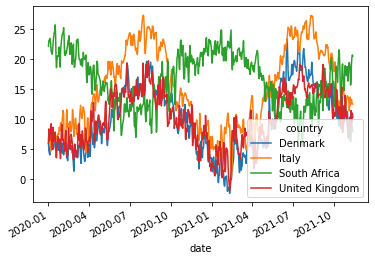

In [23]:
ax = CandT[CandT.country.isin(["Denmark", "Italy", "United Kingdom", "South Africa"])].groupby([pd.Grouper(key='date', freq='d'), 'country']).temperature.mean().unstack().plot(); 

# Apple data 

The Apple mobilitiy data contains indices for mobility, which are based on the relative search volume for trips in the Apple maps platform (releative to January 13 2020). It is a panel over location and date, where locations can be either entire countries or sub-regions or cities. We will focus on entire countries and delete all the other information. 

In [24]:
# only retain country-wide data
A = A[A.geo_type == 'country/region'].copy()
for v in ['geo_type', 'alternative_name', 'sub-region', 'country']: 
    del A[v]

## Convert from wide to long

The dataset has dates in the columns rather than rows. I.e. it is in *wide* format. 

In [25]:
# dictionaries to rename columns
# assumes that all columns from 2 and onwards are the date variables
# we have to insert a "v" in front of the variable name to force pandas 
# to think of the variable as a string. 
ren = {v:f'v{i}' for i,v in enumerate(A.columns[2:])}
ren_back = {i:v for i,v in enumerate(A.columns[2:])} # this will get us back 

R = pd.wide_to_long(A.rename(columns=ren), stubnames='v', i=['region', 'transportation_type'], j='date')

In [26]:
R = R.reset_index(level='date') # make date a variable and not a part of the index
R.date = R.date.map(ren_back) # convert from {0,1,2,...} to the correspondinig dates
R.date = pd.to_datetime(R.date) # convert from Object to Datetime 
R = R.reset_index().rename(columns={'v':'mobility', 'region':'country'})

In [27]:
# long to wide: get one row per country, and different transportation types as variables
R = R.set_index(['country', 'date', 'transportation_type']).unstack()

# collapse multilevel column index 
R.columns = [' '.join(col).strip() for col in R.columns.values]
R.sort_index(inplace=True)

# spaces in names are problematic: make underscores
R.columns = [x.replace(' ', '_') for x in R.columns.values]

In [28]:
# look at the beautiful frame
R

mobility_driving  mobility_transit  mobility_walking
country date                                                            
Albania 2020-01-13            100.00               NaN            100.00
        2020-01-14             95.30               NaN            100.68
        2020-01-15            101.43               NaN             98.93
        2020-01-16             97.20               NaN             98.46
        2020-01-17            103.55               NaN            100.85
...                              ...               ...               ...
Vietnam 2021-11-11             87.67               NaN            140.08
        2021-11-12             97.67               NaN            153.56
        2021-11-13            104.89               NaN            167.52
        2021-11-14             95.76               NaN            153.14
        2021-11-15             91.02               NaN            144.01

[42399 rows x 3 columns]

In [29]:
countries_C

,iso_code,country,country_iso2
0,AFG,Afghanistan,AF
1,OWID_AFR,Africa,NaN
2,ALB,Albania,AL
3,DZA,Algeria,AG
4,AND,Andorra,NaN
...,...,...,...
230,VNM,Vietnam,VM
231,WLF,Wallis and Futuna,NaN
232,YEM,Yemen,NaN
233,ZMB,Zambia,ZA


# Merge Datasets

## temperatures 


In [30]:
C2 = pd.merge(C, CandT[['iso_code', 'temperature', 'date']], on=['iso_code', 'date'], how='left')

## mobility

In [31]:
C2 = C2.set_index(['country', 'date']).sort_index()

In [32]:
C2 = C2.join(R)

Print some details about the failed merges between the Apple and Covid datasets. 

In [33]:
cc = [c for c in R.index.get_level_values('country').unique() if c not in countries_C.country.values]
print(f'No Covid data for these countries where we have Apple data: {cc}')

No Covid data for these countries where we have Apple data: ['Czech Republic', 'Republic of Korea']


In [34]:
cc = [c for c in countries_C.country.values if c not in R.index.get_level_values('country').unique()]
print(f'There are {len(cc)} countries where we have Covid data but no Apple mobility data (e.g. {np.random.choice(cc, 3)})')

There are 174 countries where we have Covid data but no Apple mobility data (e.g. ['Pitcairn' 'Kenya' 'Kiribati'])


In [35]:
print('--- missing values in final dataset of apple mobilityi values ---')
C2[['mobility_driving', 'mobility_walking', 'mobility_transit']].isnull().mean()

--- missing values in final dataset of apple mobilityi values ---


mobility_driving    0.708168
mobility_walking    0.708168
mobility_transit    0.873209
dtype: float64

## Google data

The country region code does not conform with NOAA, so it is not currently in use. 

In [36]:
del goog['country_region_code']

Variable names are so long that it causes problems sometimes. So we shorten them a bit. 

In [37]:
goog.rename(columns={"country_region":"country", 
                    'retail_and_recreation_percent_change_from_baseline':'location_retail_and_recreation',
                    'grocery_and_pharmacy_percent_change_from_baseline':'location_grocery_and_pharmacy', 'parks_percent_change_from_baseline':'location_parks',
                    'transit_stations_percent_change_from_baseline':'location_transit_stations','workplaces_percent_change_from_baseline':'location_workplaces',
                    'residential_percent_change_from_baseline':'location_residential'}, inplace=True)

Find the rows in the Google data that we have an exact match on for country. 

In [38]:
I = goog.country.isin(C2.index.get_level_values('country'))

In [39]:
print(f'We match {100.*I.mean():5.2f}% of rows')

We match 96.35% of rows


Merge on to remaining dataset 

In [40]:
C2 = C2.join(goog[I].set_index(['country', 'date']))

# Output

In [41]:
C2.to_csv('covid.csv')

In [42]:
# delete unzipped climate data files
for y in years: 
    os.remove(f'Raw/{y}.csv')